In [1]:
from collections import Counter,defaultdict
from bs4 import BeautifulSoup as bs
from bs4 import Comment
import os
import glob
import nltk
import math
import urllib2
import time
import progressbar
from __future__ import division

In [2]:
path_to_folder = 'C:\\Users\\Isobel\\Documents\\auc\\textmining\\erowid_text'
filenames = os.listdir(path_to_folder)

test_files = filenames


In [3]:
#because of the fact that we downloaded the data to file, decided to make smaller dict 
# ref is the experience number (and therefore file name)
# {ref {drug: gender}}

def retrieve_drug_and_gender(folder):
    """
    takes a folder and opens the files inside
    then finds the foottable and extracts the gender
    then finds the beginning table and extracts the drug   
    """
    drug_dict = {}
    #put this back os.listdir
    for f in (folder):
        drug_dict[f] = {}
        open_file = open(path_to_folder + '//' + f, 'r')
        bs_f = bs(open_file, "lxml")
        #find the html table with the class footdata
        # write a check for the table
        if (bs_f.find(class_='footdata')):
            #print "yes"
            end_table = bs_f.find(class_='footdata')
            rows = end_table.findAll('tr')
            #print rows
            #the gender is listed in the table data text as the 3rd element in the table
            gender_in_table = [[td.text for td in tr.findAll("td")] for tr in rows]
            g = gender_in_table[1]
            #clumsy function that takes the 0th element of the list from g  and partitions it to return the
            #second substring
            gender = g[0].partition(':')[2]
            #get the table containing the drug information
            drug_class = [td.find('a') for td in bs_f.findAll('td', {'class' : 'dosechart-substance'})]
            #take a set of the list to remove duplicate entries
            drug = set([drug.text for drug in drug_class if drug])
            #convert to string to use in dict
            # naiave way to remove unwanted characters from string
            drug = str(drug).strip("set([")
            drug = str(drug).strip("])")
            drug_dict[f][drug] = gender
        else:
            pass
    return drug_dict

#a list of genders and the drugs
#data_set = retrieve_drug_and_gender(absolute_urls)

test_dict =  retrieve_drug_and_gender(test_files)

In [4]:
def count_gender(drug_gender_dict):
    """
    takes output of retrieve_drug_and_gender and 
    returns a dict of theccount of each gender for each drug
    """
    male_dict = {}
    female_dict = {}
    #select the second list in the item -> this is the part 
    #containing the information about gender
    for i in drug_gender_dict.values():
        for gender in i.values():
            #if gender is male, male_count is + 1
            if "Male" in gender:
                # we need to add 1 to the count specific to that drug
                #use a set to ensure no repetition of drug name in table
                for drug in i.keys():
                    if not drug in male_dict:
                        #if the drug is not already a key in the dict, then the count is 1
                        # as we havent seen it before
                        male_dict[drug] = 1
                    else:
                        # the count is incremented by 1
                        male_dict[drug] += 1
            #add 1 to female count if the gender is female
            if "Female" in gender:
                #check that there is no repetition of the same drug in a single entry
                for drug in i.keys():
                    if not drug in female_dict:
                        #the count is 1
                        female_dict[drug] = 1 
                    else:
                        # the count is incremented by 1
                        female_dict[drug] += 1
            else:
                #if gender is not specified, we ignore it
                pass
    return female_dict, male_dict

In [5]:
gender_count_tuple = count_gender(test_dict)

[("u'Salvia divinorum'", 837), ("u'Cannabis'", 519), ("u'Mushrooms'", 387), ("u'LSD'", 286), ("u'MDMA'", 256)]


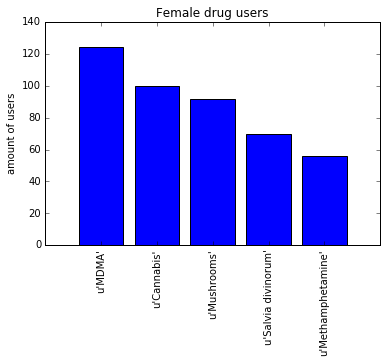

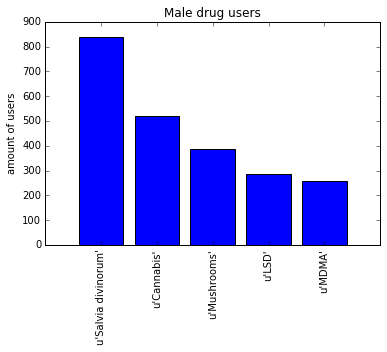

In [19]:
#display the results as bar plots

%matplotlib inline
import matplotlib.pyplot as plt


#the first dict is female drug users
female_drugs = gender_count_tuple[0]
#clean the empty string values '' from the dict
cleaned_female_drugs = {i:female_drugs[i] for i in female_drugs if i!=''}
#the second dict is male drug users
male_drugs = gender_count_tuple[1]
#clean the empty string values from the dict
cleaned_male_drugs = {i:male_drugs[i] for i in male_drugs if i!=''}

#get the top 5 used drugs from male and female users useing the cleaned dicts
top_female_drugs = Counter(cleaned_female_drugs).most_common(5)
top_male_drugs = Counter(cleaned_male_drugs).most_common(5)
print top_male_drugs

#display the results as a bar chart
#female drug users plotted onto a graph
plt.bar(range(len(top_female_drugs)), [x[1] for x in top_female_drugs], align="center")
plt.xticks(range(len(top_female_drugs)), [x[0] for x in top_female_drugs], rotation='vertical')
#label the axis
plt.ylabel('amount of users')
plt.title('Female drug users')

plt.show()

#male drug users plotted onto a drug
plt.bar(range(len(top_male_drugs)), [y[1] for y in top_male_drugs], align="center")
plt.xticks(range(len(top_male_drugs)), [y[0] for y in top_male_drugs], rotation='vertical')
#label the axis 
plt.ylabel('amount of users')
plt.title('Male drug users')

plt.show()

In [7]:
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords 

stop_words = set(stopwords.words('english'))

In [8]:
#function to make clouds 
def make_cloud(text):
    wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)  # Note that this is different from the code on the web! You must specify the font path
    # Open a plot of the generated image.
    plt.imshow(wordcloud)
    plt.axis("off")
    return plt.show()

In [22]:

def find_LSD(in_dict):
    """
    takes a dict and converts it to it's items (a tuple)
    if LSD is in the second part of the tuple
    we return the first part of the tuple
    which is the ID"""
    ID = []
    item = in_dict.items()
    for i in item:
        if  "u'LSD'" in i[1]:
            key_id = i[0]
            ID.append(key_id)
        if "u'Mushrooms'" in i[1]:
            key_id = i[0]
            ID.append(key_id)
    return ID
        
LSD_ID = find_LSD(test_dict)


In [23]:
def clean_text(list_of_id):
    no_stop_words = []
    l = []
    for i in list_of_id:
        """
        takes a list of drug ids and opens the corresponding files
        then returns the cleaned and tokenised message
        """
        open_file = open(path_to_folder + '//' + i, 'r')
        text = open_file.read()
        #extract the txt after the <!-- Start Body --> comment
        body = text.partition('<!-- Start Body -->')[2]
        #extract text before <!-- End Body --> comment
        message = body.partition('<!-- End Body -->')[0]
        #lower case and remove the <br>
        message = message.lower()
        no_br = message.replace('<br>', '')
        no_slash_br = no_br.replace('<br/>', '')
        #remove stop words
        no_stop_words = [w for w in no_slash_br.split() if w not in stop_words]
        l.extend(no_stop_words)
    return l
        

tokenised = clean_text(LSD_ID)  
#print tokenised

In [24]:
count = Counter()

def word_count(l):
    """
    takes a list and returns count of words
    """
    for word in l:
        count[word] += 1
    return count

In [42]:
print word_count(tokenised).most_common(30)


[('like', 115720), ('would', 85580), ('felt', 84980), ('could', 69560), ('one', 65020), ('time', 64560), ('back', 61120), ('around', 52980), ('trip', 47460), ('started', 47440), ('get', 46260), ('really', 44680), ('got', 42820), ('went', 40700), ('feel', 40300), ('looked', 39840), ('thought', 39520), ('still', 38980), ('me.', 38760), ('go', 38640), ('seemed', 38000), ('going', 36560), ('see', 35500), ('began', 35440), ('everything', 35360), ('feeling', 34460), ('much', 32760), ('first', 32560), ('decided', 32080), ('even', 32000)]
6909


In [73]:
#make the list of spirit words - primarily taken from wikipedia

spiritual_words = ['god', 'spirit', 'heaven', 'hell', 'universe','magic','atheist', 'creation', 'concious', 'exist']

def specific_word_count(list_words, counter_object):
    wc = {}
    for w in list_words:
        w_count = counter_object[w]
        wc[w] = w_count
    return wc

spirit_count =  specific_word_count(spiritual_words, word_count(tokenised))
        
#print spirit_count

print spirit_count.values()

[1620, 4365, 135, 14805, 1305, 180, 2880, 9315, 9450, 3240]


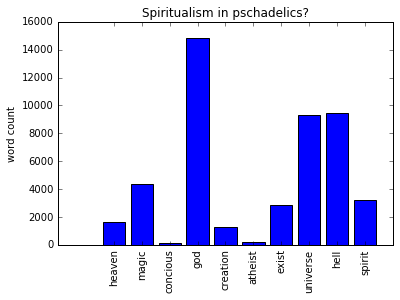

In [74]:
#make a graph of the spirit words

#display the results as bar plots

%matplotlib inline


plt.bar(range(len(spirit_count.values())), [x for x in spirit_count.values()], align="center")
plt.xticks(range(len(spirit_count.keys())), [x for x in spirit_count.keys()], rotation='vertical')
#label the axis
plt.ylabel('word count')
plt.title('Spiritualism in pschadelics?')

plt.show()
